In [1]:
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from functions import *

from tqdm import tqdm

Using cupy


In [2]:
@dataclass
class Config:
    nx: int = 800
    ny: int = 400
    steps: int = 10000
    output_stride: int = 500
    molecular_weights: tuple[float, float, float] = (5, 5)
    pressure_frac: tuple[float, float, float] = (0.01, 0.99)
    total_pressure: float = 1.0
    theta: float = 0.5
    nB: int = 11

    vx = 0.1

In [3]:
def initialise_chamber(config: Config, absorption_coefficient, ini_slope):
    nx, ny = config.nx, config.ny
    species = 2
    phi = 1.0 / xp.array(config.molecular_weights, dtype=xp.float64)

    # Partial pressures for each species
    psigma = xp.zeros((species, nx, ny), dtype=xp.float64)
    mid = nx // 2
    pressure = xp.array(config.pressure_frac, dtype=xp.float64) * config.total_pressure
    for s in range(species):
        psigma[s, :, :] = pressure[s]

    # Convert partial pressures to densities: p_s = phi_s * rho_s / 3
    rho_s = xp.zeros_like(psigma)
    for s in range(species):
        rho_s[s] = 3.0 * psigma[s] / phi[s]

    # Initial populations from equilibrium with zero velocity
    f = xp.zeros((species, 9, nx, ny), dtype=xp.float64)
    ux_s = xp.ones((species, nx, ny), dtype=xp.float64) * config.vx
    uy_s = xp.zeros((species, nx, ny), dtype=xp.float64)
    feq = equilibrium(f, rho_s, phi, ux_s, uy_s)
    f[...] = feq
    return f, phi

In [4]:
def lattice_flow_object(f, phi, step, non_absorb_mask, bc_top, bc_bottom):
    f_streamed = xp.zeros_like(f)
    for i in range(w.shape[0]): # for each species
        f_streamed[:, i, :, :] = xp.roll(f[:, i, :, :], (int(D2Q9_CX[i]), int(D2Q9_CY[i])),axis=(1, 2))

    nx = f_streamed.shape[2]
    ny = f_streamed.shape[3]
    X, Y = np.meshgrid(range(nx), range(ny))
    cylinder = ((X-(nx/5))**2 + (Y-(ny/2))**2) < (ny/8)**2
    cylinder = cylinder.T
    cylinder[:, :1] = True
    cylinder[:, -1:] = True

    inside_boundary = f_streamed[:, :, cylinder]
    inside_boundary = inside_boundary[:, [0,5,6,7,8,1,2,3,4], :] #OPPOSITE
    f_streamed[:, :, cylinder] = inside_boundary

    ux_in = xp.ones(f_streamed.shape[3]) * Config.vx
    uy_in = xp.ones(f_streamed.shape[3]) * 0

    #for s in range(f_streamed.shape[0]):

    C_in_1 = xp.ones(ny) * 3 * 1 / phi[0]
    C_in_1[ny//2 - ny//5: ny//2 + ny//5] *= 0.5
    f_in_eq_1 = eq_single_boundary(C_in_1, phi[0], ux_in, uy_in)
    f_streamed[0, :, 0, :] = f_in_eq_1

    C_in_2 = xp.ones(ny) * 3 * 1 / phi[1]
    C_in_2 *= 0.1
    C_in_2[ny//2 - ny//5: ny//2 + ny//5] *= 6
    f_in_eq_2 = eq_single_boundary(C_in_2, phi[1], ux_in, uy_in)
    f_streamed[1, :, 0, :] = f_in_eq_2

    f_streamed[:, :, -1, :] = f_streamed[:, :, -2, :]

    return f_streamed

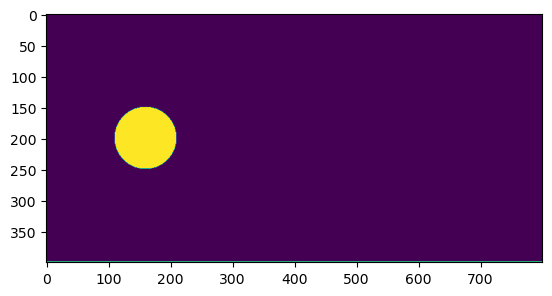

In [5]:
nx = Config.nx
ny = Config.ny
X, Y = np.meshgrid(range(nx), range(ny))

cylinder = ((X-(nx/5))**2 + (Y-(ny/2))**2) < (ny/8)**2
cylinder = cylinder.T

cylinder[:, :1] = True
cylinder[:, -1:] = True

plt.imshow(cylinder.T)

In [6]:
def main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, ini_slope, Config):
    cfg = Config()
    out_dir = 'demo_frames'

    f, phi = initialise_chamber(cfg, absorption_coefficient, ini_slope)
    molecular_weights = xp.array(cfg.molecular_weights, dtype=xp.float64)


    for step in tqdm(range(cfg.steps + 1)):
        #f_old = xp.copy(f)

        if step % cfg.output_stride == 0:
            save_concentration_frames(f, phi, step, molecular_weights)
            rho_s, ux_s, uy_s, rho_mix, p_mix = calculate_moment(f, phi)
            plot_vector(to_numpy(ux_s[0]), to_numpy(uy_s[0]), zoom = 0.2, skip = 20, shapes=cylinder)
        if step == cfg.steps:
            break
        f = bgk_step(f, molecular_weights, phi, cfg.nB, lattice_flow_object, step,
                     non_absorb_mask, bc_top, bc_bottom)

    print(f"Saved frames to {out_dir}")

    return f

In [7]:
absorption_coefficient = 100
bc_top = None
bc_bottom = None
non_absorb_mask = None

  0%|          | 0/10001 [00:00<?, ?it/s]

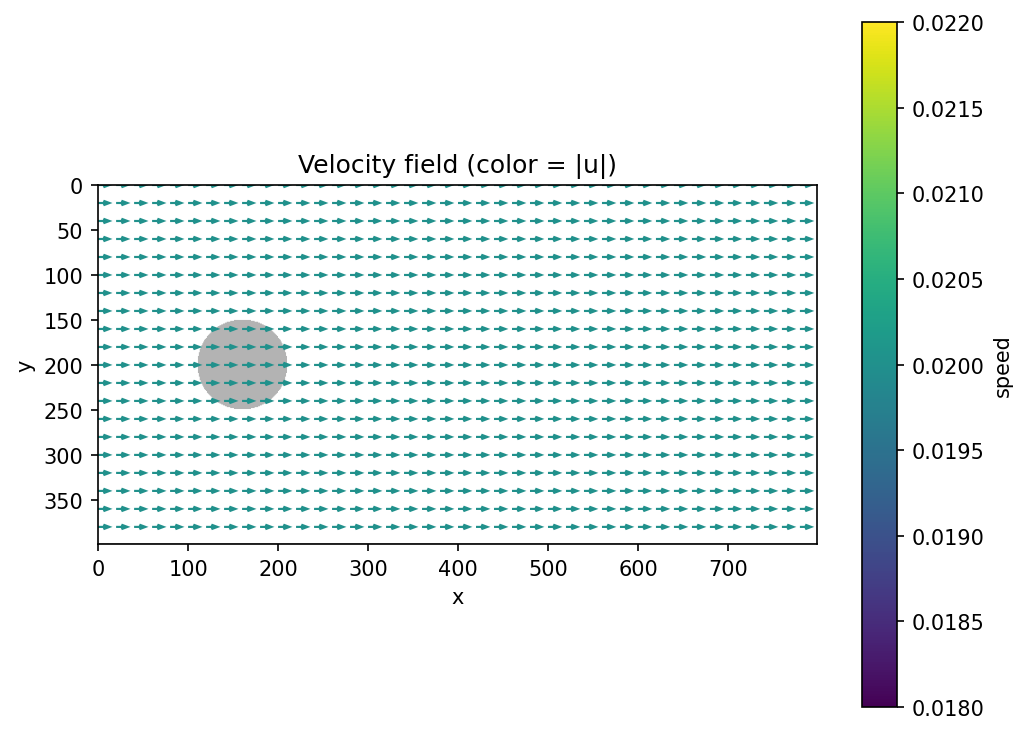

  5%|▍         | 496/10001 [00:12<03:39, 43.37it/s]

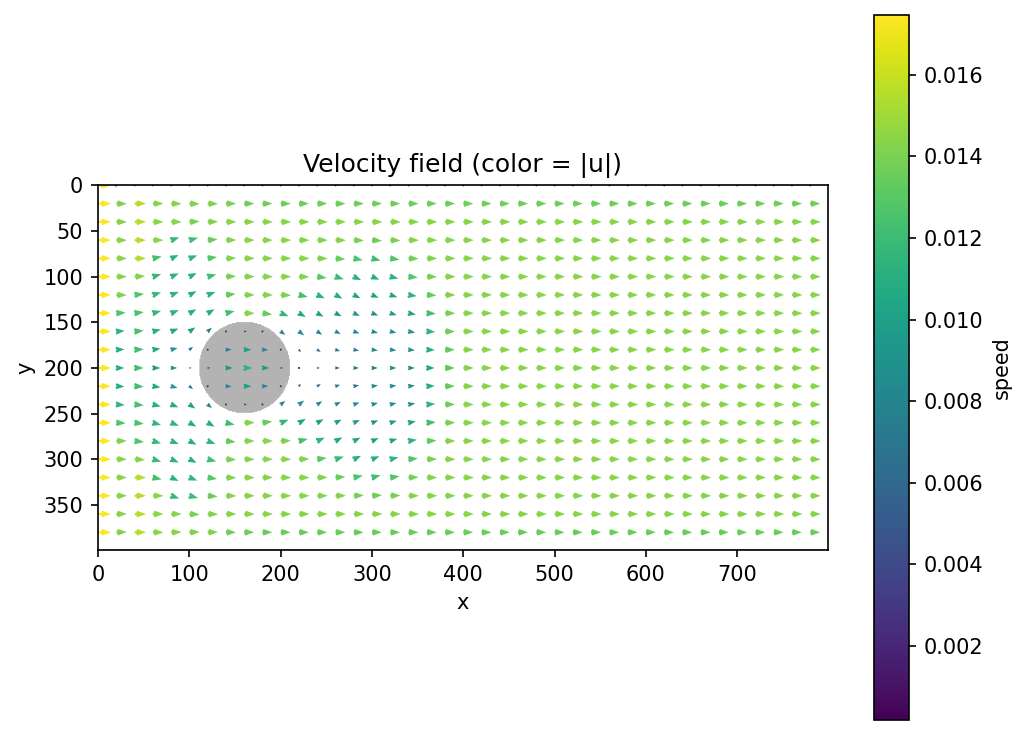

 10%|▉         | 996/10001 [00:23<03:23, 44.15it/s]

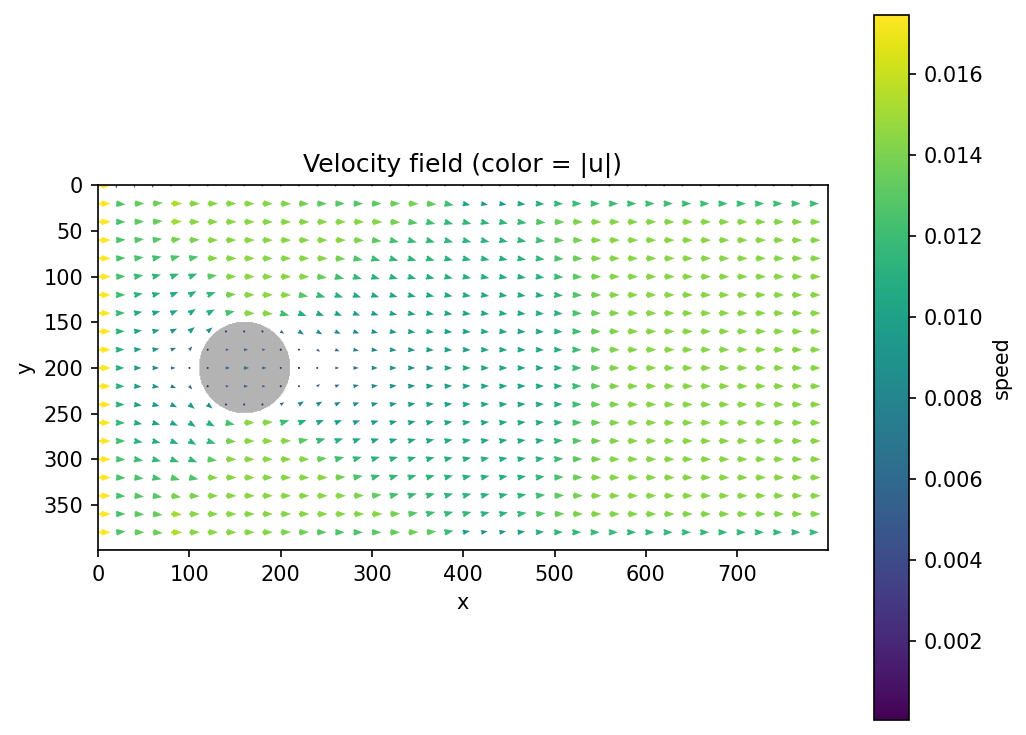

 15%|█▍        | 1496/10001 [00:35<03:17, 43.07it/s]

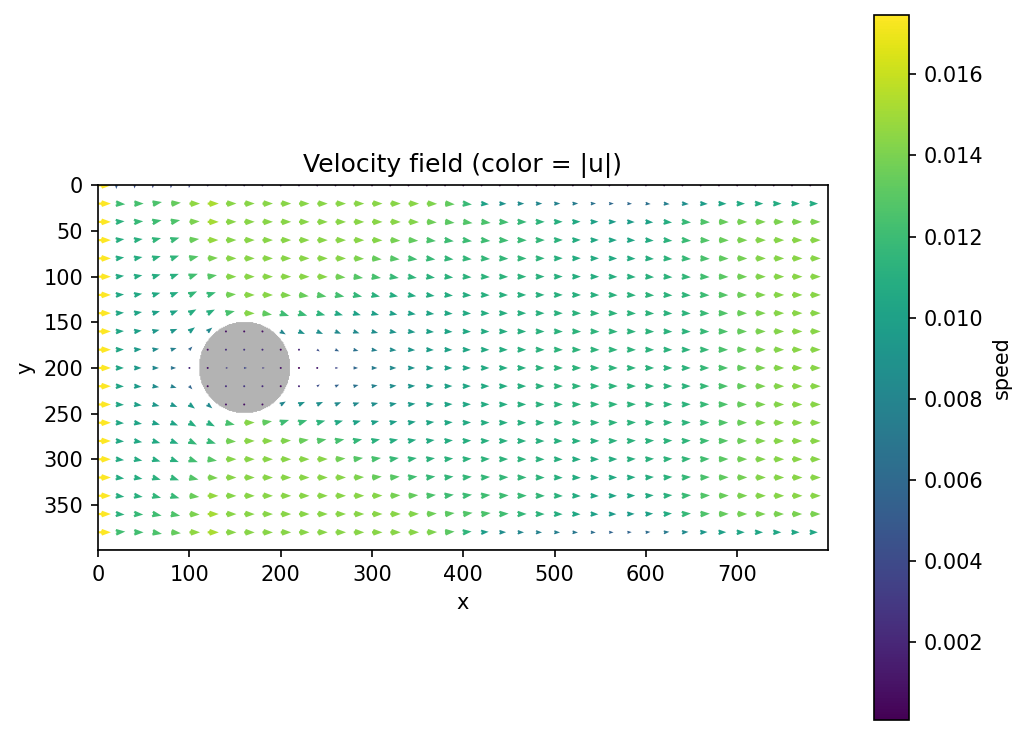

 16%|█▌        | 1616/10001 [00:38<03:13, 43.32it/s]

In [ ]:
f= main(non_absorb_mask, bc_top, bc_bottom, absorption_coefficient, True, Config)